In [4]:
import numpy as np
import cupy as cp
import time
import pandas as pd
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
import numpy as np
import pandas as pd
import psutil
# Disables the C++ errors in RDKIT when forming mols
RDLogger.DisableLog('rdApp.*') 

RADIUS = 3
FPSIZE = 512
SAMPLE_SMILE = "c1cc(ccc1[C@H]([C@@H](CO)NC(=O)C(Cl)Cl)O)[N+](=O)[O-]"
RETURN_NUM_RESULTS = 200
SAMPLE_NAME = "result_files/GPU_fp_search_chembl_large"
CSV_REF_DB = "chembl_csv.csv"

In [5]:
def prepare_smiles() -> list:
    # Takes a CSV and looks for a column named smiles
    start = time.time()
    #db_smile_list = pd.read_csv(CSV_REF_DB, delimiter="\t", names=["smile"])
    db_smile_list = pd.read_csv(CSV_REF_DB, names=["smile"])
    smile_list = []
    cleaned_mols = []
    for x in db_smile_list['smile']:
        mol = Chem.MolFromSmiles(x)
        if mol:
            cleaned_mols.append(mol)
            smile_list.append(x)
    del db_smile_list
    # cleaned_mols = [x for x in mols if x is not None]
    # smile_list = [Chem.MolToSmiles(x) for x in cleaned_mols]
    # smile_list_df = pd.DataFrame(smile_list)

    end = time.time()
    print(f"{end - start} seconds to read in {len(smile_list)} files")
    return cleaned_mols, smile_list

def generate_fps(cleaned_mols: list) -> list("ExplicitBitVect"):
    # Generate FP for db smiles
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=RADIUS,fpSize=FPSIZE)
    return [mfpgen.GetFingerprint(m) for m in cleaned_mols]

def prepare_numpy_arrays(list_of_fps: list) -> np.array:
    list_fp_np = []
    for fp in list_of_fps:
        numpy_arr_fp = np.zeros((0,), dtype=np.uint8)
        DataStructs.ConvertToNumpyArray(fp, numpy_arr_fp)
        list_fp_np.append(numpy_arr_fp)

    return np.stack(list_fp_np)

def gen_sample_fps(sample_smile: list) -> np.array:
    # Generate FP for submitted/sample smile
    mol = Chem.MolFromSmiles(sample_smile)
    mfpgen_example = rdFingerprintGenerator.GetMorganGenerator(radius=RADIUS,fpSize=FPSIZE)
    sample_fps = mfpgen_example.GetFingerprint(mol)
    numpy_arr_fp = np.zeros((0,), dtype=np.uint8)
    DataStructs.ConvertToNumpyArray(sample_fps, numpy_arr_fp)
    return numpy_arr_fp

def setup_GPU_arrays(list_of_fps: list, sample_fps : object) -> None:
    cu_arr_list_fp = cp.array(list_of_fps, dtype=cp.uint8)
    cu_arr_sam_fp = cp.array(sample_fps, dtype=cp.uint8)
    return cu_arr_list_fp, cu_arr_sam_fp

def run_on_GPU(cu_arr_list_fp : cp.array, cu_arr_sam_fp : cp.array) -> np.array:
    and_num = cp.bitwise_and(cu_arr_list_fp, cu_arr_sam_fp)
    return cp.asarray(cp.sum(and_num, axis=1) / cp.sum((cu_arr_list_fp + cu_arr_sam_fp - and_num), axis=1), dtype=cp.float16)
    
def results_to_df(gpu_results : cp.array, smile_from_db : list) -> pd.DataFrame:
    # Convert results to numpy
    result_df = pd.DataFrame(gpu_results.tolist(), columns=["similarity"]).round(2)
    result_df["smiles"] = smile_from_db
    return result_df.sort_values(by="similarity", ascending=False).head(RETURN_NUM_RESULTS)

def return_stats() -> dict:
    stats = {
        "radius" : RADIUS,
        "fpsize" : FPSIZE
    }
    return stats

546.3992383480072 seconds to read in 2372673 files


C:\Users\sulsb\anaconda3\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


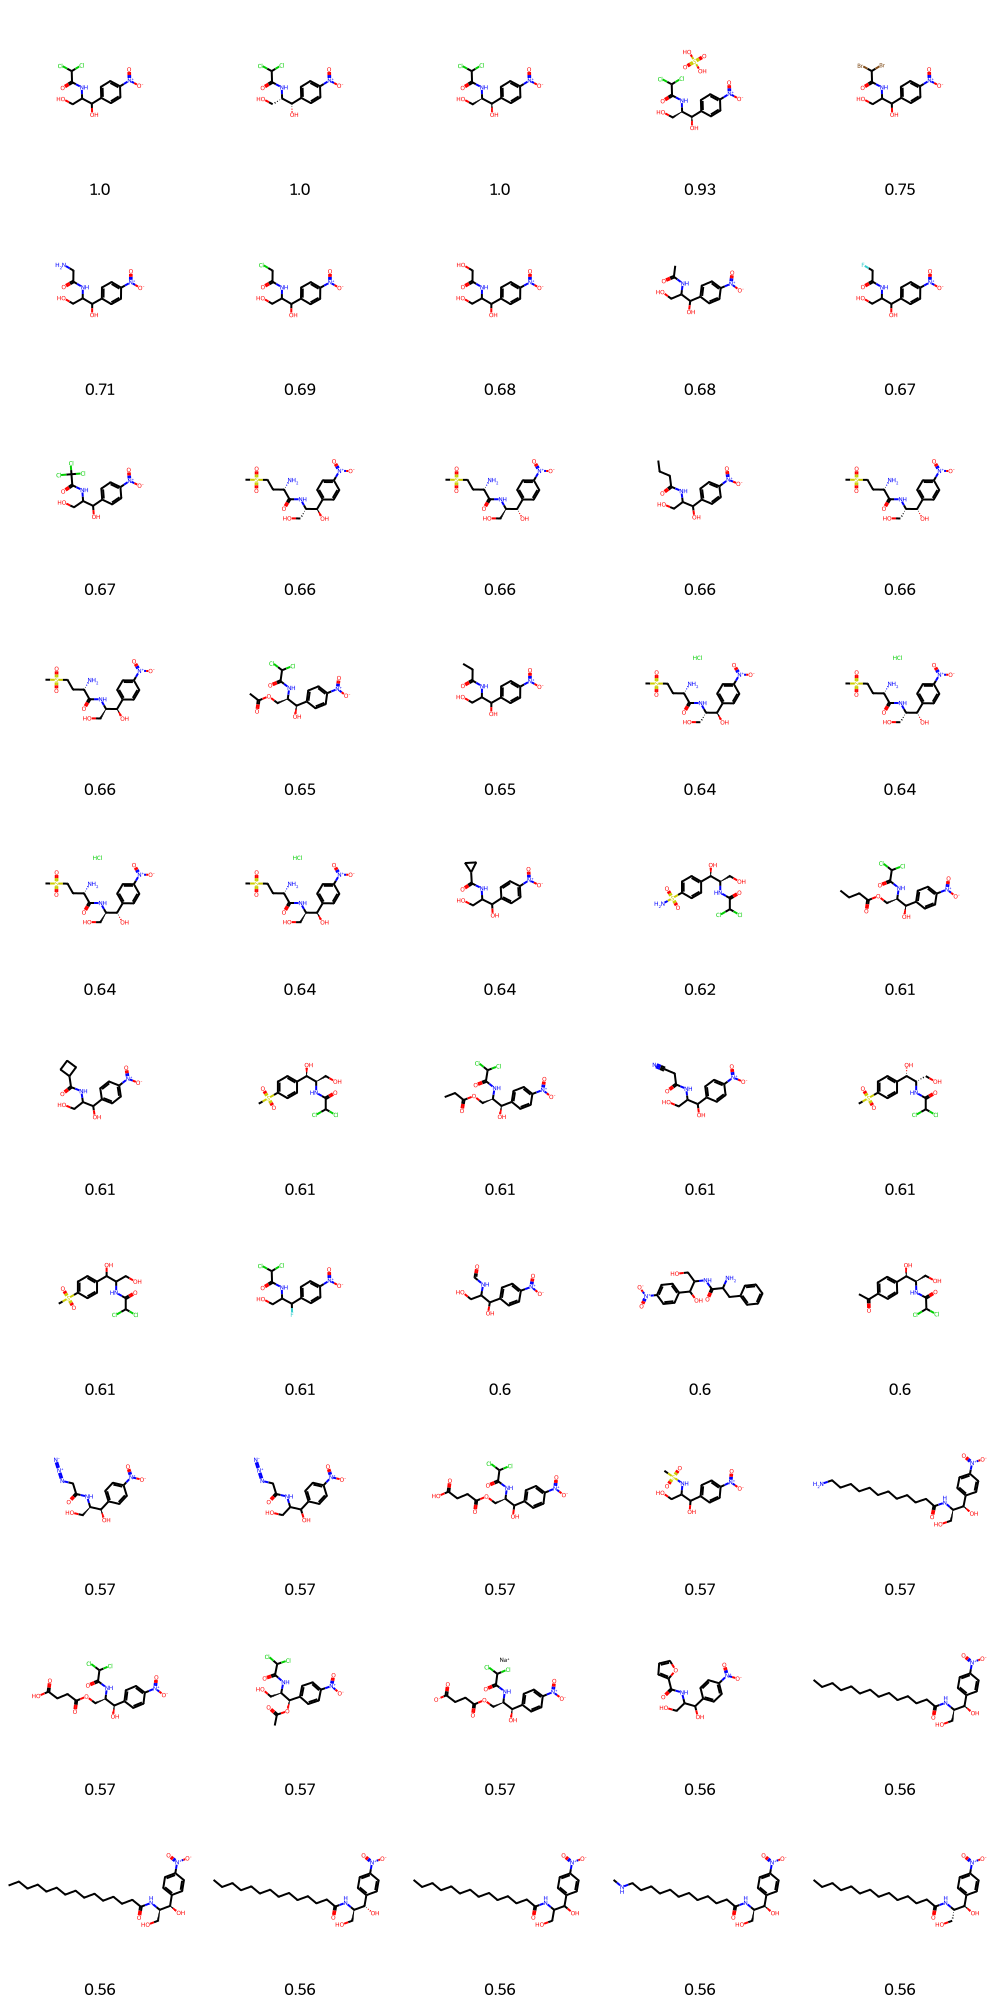

In [6]:
cleaned_mols, smile_from_db = prepare_smiles()
ref_fps = generate_fps(cleaned_mols)
sample_fps = gen_sample_fps(SAMPLE_SMILE)
list_of_fps = prepare_numpy_arrays(ref_fps)
cu_arr_list_fp, cu_arr_sam_fp = setup_GPU_arrays(list_of_fps, sample_fps)
gpu_results = run_on_GPU(cu_arr_list_fp, cu_arr_sam_fp)
results = results_to_df(gpu_results, smile_from_db)
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(results, smilesCol='smiles')
PandasTools.FrameToGridImage(results, legendsCol="similarity", molsPerRow=5)
